# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from scipy.spatial import procrustes

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.monkey_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root

finally:
    os.chdir(nbPath)


%run "_dataset-selection.ipynb"


# procrustes comparison

## 2 monkeys, same epoch



load the data

In [2]:
full_list_MCx = []
for animal, sessionList in GoodDataList[defs.areas[2]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list_MCx.append((animal,sessionList))
full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
# load the DFs
warnings.filterwarnings("ignore")
allDFs_MCx = []
for animal, session in full_list_MCx:
    path = root/animal/session
    allDFs_MCx.append(defs.prep_general(dt.load_pyal_data(path)))


warnings.filterwarnings("default")


pairFileList1 = []
for I, (animal1,session1) in enumerate(full_list_MCx):
    for J, (animal2,session2) in enumerate(full_list_MCx):
        if J<=I or animal1 == animal2: continue  # to repetitions
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
        pairFileList1.append((I,J))

print(f'{len(pairFileList1)=}')

len(pairFileList1)=126


test that `dt.norm_mov` isn't doing something weird!

Mihili with 114 units


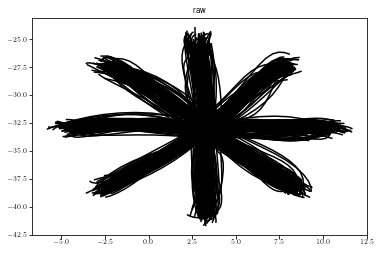

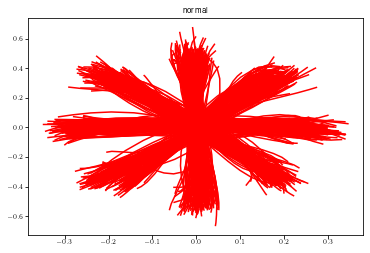

In [11]:
DF=[]
for d in allDFs_MCx:
    if d.session[0] in ['Mihili:09-29-2014','Chewie:09-14-2016']:
        DF.append(d)

df = DF[1]
df1 = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
df2 = dt.normal_mov(df1, 'pos')


for data1 in df1.pos:
    plt.plot(data1[:,0],data1[:,1],'k')
plt.title('raw')

plt.figure()
i=0
for data2 in df2.pos:
    plt.plot(data2[:,0],data2[:,1],'r')
    i+=1
    # if i>50:    break
plt.title('normal')
print(f'{df.monkey[0]} with {df.MCx_rates[0].shape[1]} units')

collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

min_trials=15
min_time=15


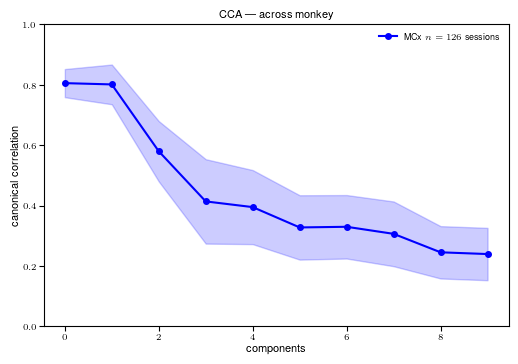

In [3]:
side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
side2df = [allDFs_MCx[j] for _,j in pairFileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
AllData2 = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')

warnings.filterwarnings("default")

allCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
    allCCs0.append(dt.procrustes_wrapper(data1, data2))
allCCs0 = np.array(allCCs0).T

# plot
_,ax = plt.subplots(dpi=100)
utility.shaded_errorbar(ax, allCCs0, color='b', marker = 'o', label=f'{defs.areas[2]} $n={allCCs0.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('components')
ax.legend()
ax.set_ylabel('canonical correlation')
ax.set_title('CCA --- across monkey', usetex=True);


min_trials=15
min_time=15


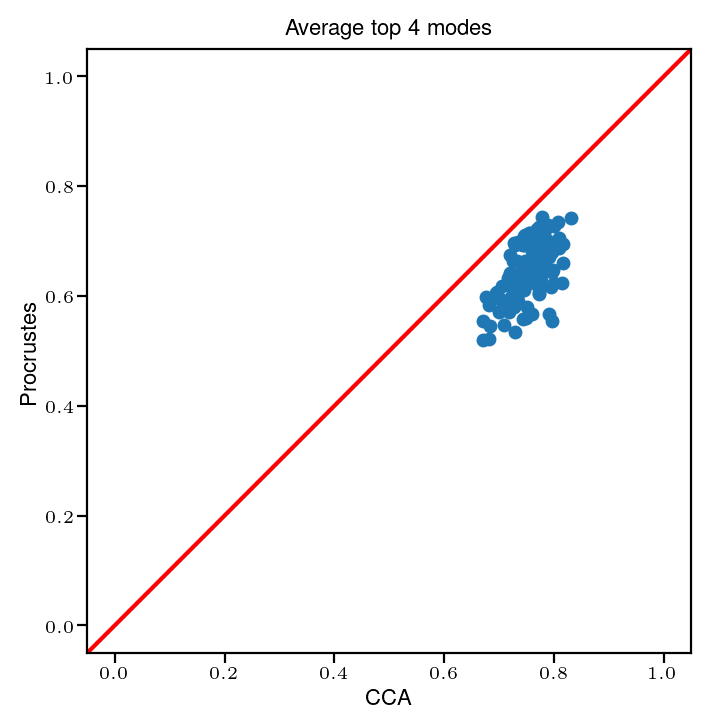

In [4]:
side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
side2df = [allDFs_MCx[j] for _,j in pairFileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
AllData2 = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')

warnings.filterwarnings("default")

allPro=[]
allCC=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
    allPro.append(dt.procrustes_wrapper(data1, data2))
    allCC.append(dt.canoncorr(data1, data2))
allCC = np.array(allCC).T
allPro = np.array(allPro).T

# plot
fig, ax = plt.subplots(1, 1, dpi=200)

ax.scatter(allCC[:4,:].mean(axis=0), allPro[:4,:].mean(axis=0))
ax.axline([0, 0], [1, 1], color='r')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(min(xlim[0],ylim[0]), max(xlim[1], ylim[1]))
ax.set_ylim(min(xlim[0],ylim[0]), max(xlim[1], ylim[1]))
ax.set_aspect('equal')

ax.set_xlabel('CCA')
ax.set_ylabel('Procrustes')
ax.set_title('Average top 4 modes')
# ax.ticklabel_format(style='scientific', scilimits=(6,6), useMathText=True)

fig.savefig(params.figPath / 'procrustes-CCA.pdf', format='pdf', bbox_inches='tight')

## Lower bound

In [5]:
single_FileList1 = []
for I, (animal1,session1) in enumerate(full_list_MCx):
    for J, (animal2,session2) in enumerate(full_list_MCx):
        if J<=I or animal1 == animal2: continue  # to repetitions
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
        single_FileList1.append((I,J))

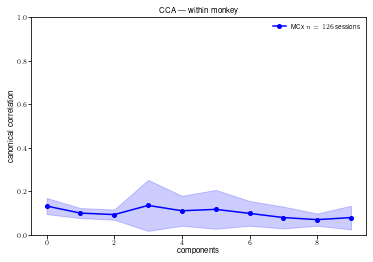

In [6]:
n_iter = params.n_iter

#MCx
side1df = [allDFs_MCx[i] for i,_ in single_FileList1]
side2df = [allDFs_MCx[j] for _,j in single_FileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, defs.prep_epoch, area=defs.areas[2], model=defs.n_components)
AllData1_ = dt.get_data_array(side2df, defs.fixation_epoch, area=defs.areas[2], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData1_.shape),axis=0)

warnings.filterwarnings("default")

inCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData1_):
    r = []
    for n in range(n_iter):
        sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
        sessionData2_sh = params.rng.permutation(sessionData2,axis=0)

        data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
        r.append(dt.procrustes_wrapper(data1, data2))
    inCCs0.append(r)
inCCs0 = np.array(inCCs0)
CC_lower_bound_MCx = np.percentile(inCCs0, 1, axis=1).T


# plotting
if "__file__" not in dir():
    _,ax = plt.subplots()

    utility.shaded_errorbar(ax, CC_lower_bound_MCx, color='b', marker = 'o', label=f'{defs.areas[2]} $n={CC_lower_bound_MCx.shape[1]}$ sessions')
    ax.set_ylim([0,1])
    ax.set_xlabel('components')
    ax.legend()
    ax.set_ylabel('canonical correlation')
    ax.set_title('CCA --- within monkey', usetex=True);

## Upper bound

In [7]:
single_FileList1 = []
for I, _ in enumerate(full_list_MCx):
    single_FileList1.append(I)



warnings.filterwarnings("ignore")
side1df = [allDFs_MCx[i] for i in single_FileList1]
AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)

warnings.filterwarnings("default")

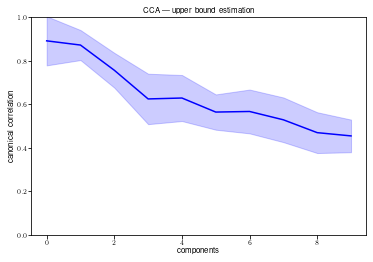

In [8]:
n_iter = params.n_iter

n_shared_trial1 = AllData1.shape[2]
trialList1 = np.arange(n_shared_trial1)


CCs1=[]
for session, sessionData in enumerate(AllData1):
    r = []
    for n in range(n_iter):
        params.rng.shuffle(trialList1)
        # non-overlapping randomised trials
        trial1 = trialList1[:n_shared_trial1//2]
        trial2 = trialList1[-(n_shared_trial1//2):]
        data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
        r.append(dt.procrustes_wrapper(data1, data2))
    CCs1.append(r)
CCs1 = np.array(CCs1)
CC_upper_bound_MCx = np.percentile(CCs1, 99, axis=1).T


if "__file__" not in dir():
    _,ax = plt.subplots()
    M1_Lines,_ = utility.shaded_errorbar(ax, CC_upper_bound_MCx, color='b', label='MCx')

    plt.ylim([0,1])
    plt.xlabel('components')
    plt.ylabel('canonical correlation')
    plt.title('CCA --- upper bound estimation', usetex=True);

Main plot

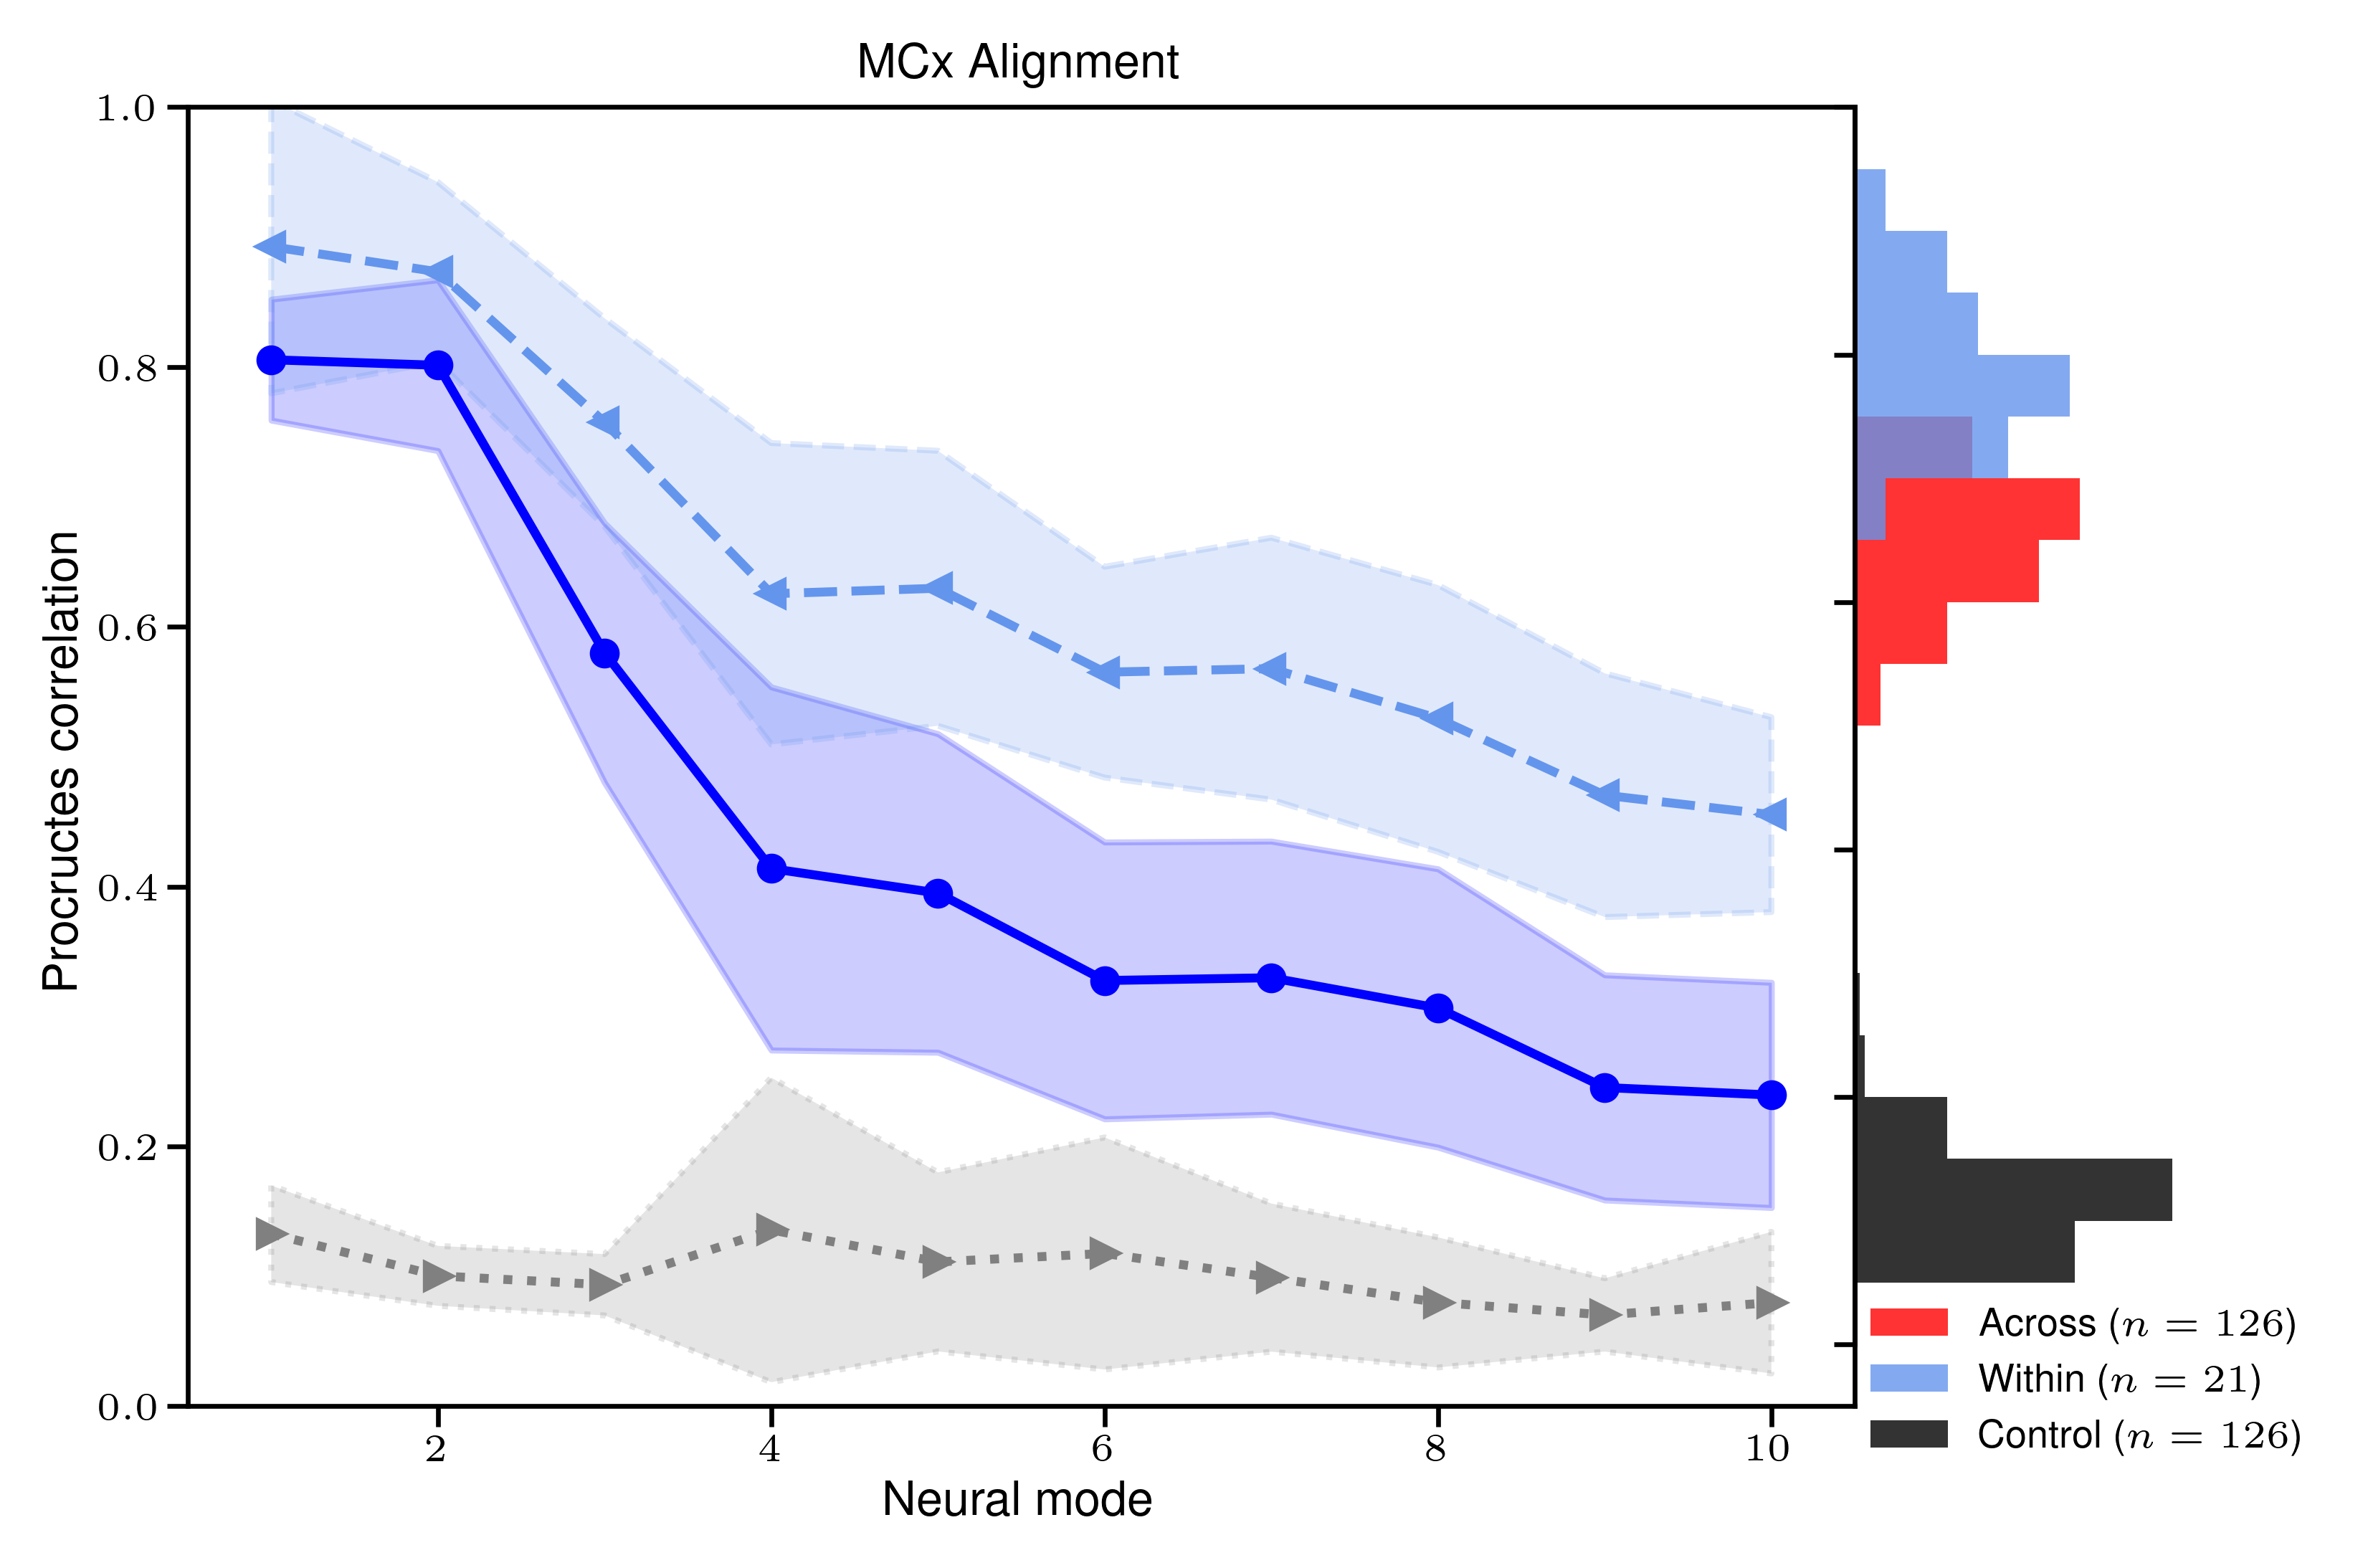

In [15]:

plt.close('all')
set_rc()
fig=plt.figure()
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

ax = fig.add_subplot(gs[0])
ax_hist = fig.add_subplot(gs[1])


utility.shaded_errorbar(ax, np.arange(1,defs.n_components+1), allCCs0, color='b', marker = 'o', label=f'Across, $n={allCCs0.shape[1]}$')

utility.shaded_errorbar(ax, np.arange(1,defs.n_components+1), CC_upper_bound_MCx, color='cornflowerblue', marker = '<', ls='--', label=f'Within, $n={CC_upper_bound_MCx.shape[1]}$')

utility.shaded_errorbar(ax, np.arange(1,defs.n_components+1), CC_lower_bound_MCx, color='gray', marker = '>', ls=':', label=f'Control, $n={CC_lower_bound_MCx.shape[1]}$')

ax.set_ylim([0,1])
ax.set_xlim([.5,defs.n_components+.5])
ax.set_xlabel('Neural mode')
ax.set_title(f'{defs.areas[2]} Alignment')
ax.set_ylabel('Procructes correlation')


#plot the hist

bins = np.arange(0,1,0.05)
ax_hist.xaxis.set_visible(False)
ax_hist.set_facecolor('None')
ax_hist.spines['bottom'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['left'].set_bounds([0,1])
ax_hist.set_ylim([-.05,1])
ax_hist.hist(allCCs0[:4,:].mean(axis=0), bins=bins, density=True, label=f'Across ($n={allCCs0.shape[1]}$)',
        color=params.colors.MainCC, alpha=.8, orientation='horizontal')
ax_hist.hist(CC_upper_bound_MCx[:4,:].mean(axis=0), bins=bins, density=True,label=f'Within ($n={CC_upper_bound_MCx.shape[1]}$)',
        color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
ax_hist.hist(CC_lower_bound_MCx[:4,:].mean(axis=0), bins=bins, density=True, label=f'Control ($n={CC_lower_bound_MCx.shape[1]}$)',
        color=params.colors.LowerCC, alpha=.8, orientation='horizontal')

ax_hist.tick_params('y', direction='out')
ax_hist.set_yticklabels([])
ax_hist.legend(loc=(0,-.05))


fig.savefig(params.figPath / 'monkey-procrustes-modes.pdf', format='pdf', bbox_inches='tight')